<a href="https://colab.research.google.com/github/lit2020/class-deep-learning/blob/main/%5BDL%5D201902656_%EA%B9%80%EA%B8%B0%EC%9B%85_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import, GPU/CPU 설정

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
random.seed(1412)
torch.manual_seed(1412)
if device == 'cuda':
    torch.cuda.manual_seed_all(1412)

cpu


# 데이터셋 로드

In [62]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             transform = transforms.ToTensor(),
                                             download=True
                                             )
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             transform = transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


# Batch Generation

In [63]:
batch_size = 100
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size,
                         shuffle=True)

x type :  <class 'torch.Tensor'>
x.shape :  torch.Size([100, 3, 32, 32])
x[0] shape :  torch.Size([3, 32, 32])
y type :  <class 'torch.Tensor'>
y.shape :  torch.Size([100])
y[0] :  tensor(0)
permuted x[0] shape :  torch.Size([32, 32, 3])


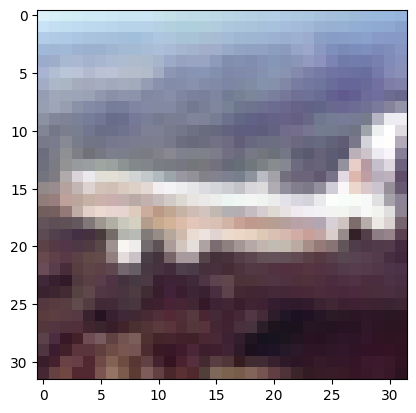

In [64]:
for i, data in enumerate(train_loader):
    x, y = data # features and labels

    print('x type : ', type(x))
    print('x.shape : ', x.shape) # [100(instances), 3(RGR), 32, 32 (width, height)]
    print('x[0] shape : ', x[0].shape) # [3, 32, 32]
    print('y type : ', type(y))
    print('y.shape : ', y.shape) # [100 (label for each image)]
    print('y[0] : ', y[0]) # class number (0~9)

    # x[0]의 shape은 (3, 32, 32)로 채널 차원이 가장 앞에 있음
    # plt.imshow에서는 (가로, 세로, 채널)로 사용하므로 permute 함수를 통해
    # [3, 32, 32] -> [32, 32, 3]으로 변경
    permuted_image = x[0].permute(1,2,0)
    plt.imshow(permuted_image)
    print('permuted x[0] shape : ', (permuted_image.shape))
    break

# 모델

In [65]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 1, stride = 1),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 5, stride = 2,
                                              padding = 0),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.fc = nn.Linear(3 * 3 * 128, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out=out.view(out.shape[0], -1)
        out = self.fc(out)

        return out

In [66]:
model = CNN().to(device)

In [67]:
# Hyper Parameters

num_epochs = 10
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Train

In [58]:

loss_list = []
for epoch_num in range(num_epochs):
    average_cost = 0

    for batch_idx, (x_data, y_label) in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        x_data = x_data.to(device)
        input_image = x_data.reshape(batch_size, 3, 32, 32)
        label = y_label.to(device)

        optimizer.zero_grad()
        y_predict = model(input_image)
        loss = criterion(y_predict, label)

        loss.backward()
        optimizer.step()

        average_cost = average_cost + (loss.item() / num_of_mini_batch)
        loss_list.append(loss)

    print("Epoch {} Loss {:.5f}".format(((epoch_num + 1), average_cost)))

KeyboardInterrupt: 

# validation

In [ ]:
with torch.no_grad():
    num_total_data = 0
    correct = 0

    # validation, evaluation을 위한 모드 설정
    # Drop out과 같은 레이어는, 훈련단계와 평가단계에서의 동작이 다름
    model.eval()
    for cnt_batch, (x, y) in enumerate(test_loader):
        x = x.reshape(batch_size, 3, 32, 32)
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        y_pred = F.softmax(y_pred, dim=1)
        y_pred = torch.argmax(y_pred, dim=1)
        num_total_data += len(x)
        correct += sum(y == y_pred).item()

print("Model Accuracy : {:.5f}".format(correct / num_total_data))

# ResNet Fine tuning

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
resnet

In [73]:
# fully connected 레이어의 아웃풋 노드를 1000개에서 10개로 변경
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

In [75]:
# Hyper Parameters

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)